In this notebook we are going to implement and train a neural network with PyTorch!

## Imports and Setup

We start by importing necessary modules. Don't worry if it seems a little overwhelming at first.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

ImportError: cannot import name '_cuda_endAllocateCurrentStreamToPool' from 'torch._C' (d:\ProgramData\anaconda3\envs\TorchAab\Lib\site-packages\torch\_C.cp313-win_amd64.pyd)

In [5]:
from matplotlib import pyplot as plt
from tqdm import trange

def visualize(images, labels):
    """ Visualize a batch of images."""

    fig, axes = plt.subplots(8, 8, figsize = (10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap= 'gray')
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def visualize_predictions(images, labels, predicted_labels):
    """ visualize a batch of images with their true and predicted labels.
    Titles are green if the prediction is correct red if incorrect. """
    fig, axes = plt.subplots(8, 8 , figsize = (11,12))
    for i , ax in enumerate(axes.flat):
        ax.imshow (images[i].squeeze(), cmap= 'gray')
        color = 'green' if labels[i].item() == predicted_labels[i].item() else 'red'
        ax.set_title (f"True: {labels[i].item()}\npred: {predicted_labels[i].item()}", color = color)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def plot_conf_mat(model, dataloder, device):
    """ Plot the confusion matrix for a given model and dataloader."""
    # Initialize the confusion matrix 
    total, correct = 0, 0
    conf_mat = torch.zeros((10,10))
    with torch.no_grad():
        for x,y in dataloder:
            x,y = x.to(device), y.to(device)
            pred = model(x)
            total += pred.shape[0]
            pred = torch.argmax(pred, axis= 1)
            correct += sum(pred == y ).item()
            for j in range (pred.shape[0]):
                conf_mat[y[j], pred[j].item()] += 1 
    # calculate the normalized confusion matrix 
    norm_conf_mat = conf_mat / torch.sum(conf_mat, axis = 1)
    # plot the matrix 
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title("Confusion Matrix")
    plt.xlabel("Predictions")
    plt.ylabel("Labels")
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.colorbar()
    # put number of each cell in plot
    for i in range(10):
        for j in range(10):
            c = conf_mat[j, i]
            color = "black" if c > 500 else "white"
            ax.text(i, j, str(int (c)), va = "center", ha = "center", color = color)
    plt.show()
    


# Dataset

We will use `datasets` from `torchvision` to load the [MNIST](https://yann.lecun.com/exdb/mnist/) handwritten digits dataset. You can find the list of datasets available on torchvision [here](https://pytorch.org/vision/0.8/datasets.html). Now let's take a loot at the parameters we set:



*   `root` sets the directory we store and load our data from.
*   `train` indicates wether we want the training dataset or the test dataset.
*   `transform` allows us to apply transformations to our data, here we are only going to convert the data to tensor so that they work with PyToch, however in the future notebooks you will see more complicated transformations.



In [ ]:
# Download training data from datasets.
training_data = datasets.MNIST(
    root = "data",
    train=True,
    download=True,
    transform=ToTensor()
)
# Download test data from open datasets.
test_data = datasets.MNIST(
    root= "data",
    train = False,
    download=True,
    transform= ToTensor(),
)

print(f"Training data: {training_data}\n")
print(f"Test data:{test_data}")


RuntimeError: Error downloading train-images-idx3-ubyte.gz:
Tried https://ossci-datasets.s3.amazonaws.com/mnist/, got:
<urlopen error [Errno 11001] getaddrinfo failed>
Tried http://yann.lecun.com/exdb/mnist/, got:
<urlopen error [Errno 11001] getaddrinfo failed>


As you can see there are 60000 training samples in the training dataset and there are 10000 samples in the test dataset.

# Data Loaders

To make loading and working with the data easier, we are going to use `DataLoader` from `torch.utils.data`. The `DataLoader` takes in a dataset and a `batch_size` parameter, and allows us to iterate over the dataset. Here we do one iteration just to see the data shapes:

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Iterate over the data 
for x, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape}  {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64])  torch.int64


As you can see the `x`s are of shape `[64, 1, 28, 28]` which means we have a batch of `64` images, each with `1` channel which means the images are grayscale (for example colorful images have 3 channels of red, blue and green or RGB), and of size `28x28` pixels.

Similarly the `y`s are of shape `[64]` which means we have a batch of 64 labels. In the next section we will learn more about these labels.

# Visualization

Here we will take a look at single batch of data and visualize it.

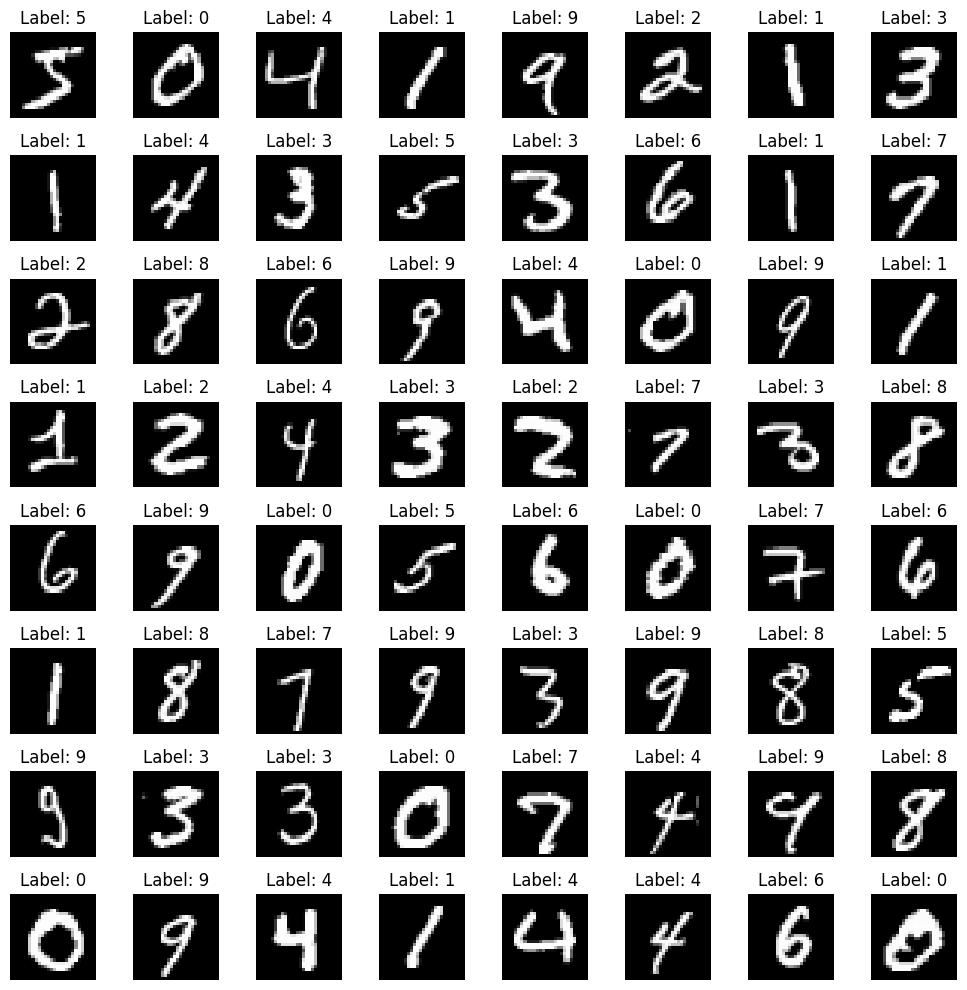

In [ ]:
Images, labels = next(iter(train_dataloader))

visualize(Images, labels)



# Device

To accelerate operations in the neural network, we move it to the GPU or MPS (for Apple silicon) if available.

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print (f"Using {device} device")

Using cuda device


# Model

Here we define our model. Recall that each batch of image has a shape of `[64, 1, 28, 28]`. For now we only want to use `Linear` layers so we must **flatten** the inputs so that we can pass it to the linear layers. The `nn.Flatten()` module allows us to do this.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward (self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Next we initialize our model.

In [ ]:
model = NeuralNetwork().to(device)
print(model)


AssertionError: Torch not compiled with CUDA enabled

# Loss Function

Since we are trying to classify the handwritten digits, we are going to use the cross entropy loss. You can see the list of loss functions in PyTorch [here](https://pytorch.org/docs/stable/nn.html#loss-functions).

In [ ]:
loss_fn = nn.CrossEntropyLoss()

# Optimizer

Next we need to setup an optimizer for training our model. We use stochastic gradient descent so we have must use the `SGD` module from `torch.optim`. We must pass the `model.parameters()` to the `SGD` optimizer and set its learning rate `lr=1e-3`. In the following sessions you will learn more about different optimizers but can also learn about the optimizers available on PyTorch [here](https://pytorch.org/docs/stable/optim.html).

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

# Training

To train the model we first set the number of epochs. For each epoch we then iterate over the entire training data and update the model parameters. For each batch of data, we must first move the data to same device as the network, then we predict the output of the model, calculate the loss, perform backward pass, update parameters, and reset the gradients.

To monitor training, we use `trange` from `tqdm` which performs similar to `range` but allows us to have a progress bar `pbar` which lets us display useful information.

In [ ]:
# Number of epochs we wish to train the model
n_epochs = 30

for _ in (pbar := trange(n_epochs)):
    # Iterate over the data
    for x,y in train_dataloader:
        # Move the datapoints to some device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the progress bar
        pbar.set_description(f"Loss = {loss.item ():.3f}")
        
        

In the following notebooks we explore more advanced methods for monitoring the training but what you

# Evaluation

Finally we can evaluate the trained model. We will start by evaluating the model on the test dataset. Here we use `torch.no_grad()` since we don't need the gradients. We iterate over the entire test dataset and print the accuracy of our model on this dataset.

In [ ]:
# Store the number of correctly classified and total labels
correct, total = 0, 0
# Disable gradient calculation 
with torch.no_grad():
    # Iterate over the test data
    for x,y in test_dataloader:
        x,y = x.to(device), y.to(device)
        # Predict 133045 the output
        logits = model(x)
        # Get the predicted label 
        pred = torch.argmax(logits, axis = 1)
        # Update the number of correctly classified labels
        correct += sum(pred == y).item()
        # Update the number of total labels
        total += pred.shape[0]

print(f"Accuracy: {100 * correct / total:.2f}%")


Let's visuzlie a batch to compare the predictions and the true labels.

In [ ]:
images, labels = next(iter(test_dataloader))
preds = torch.argmax(model(images.to(device)), axis = 1).cpu()

visualize_predictions(images, labels, preds)


To get a better sense of our model, we can plot it's confusion matrix.

In [ ]:
plot_conf_mat(model, test_dataloader,device)